## Import Statements

In [6]:
import copy

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [2]:
data = pd.read_json('../Data/data.json')

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(data[['label', 'algalBloomSheen_one_day', 'algalBloomSheen_three_day', 'algalBloomSheen_one_week']])

labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [14]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Feature Correlation

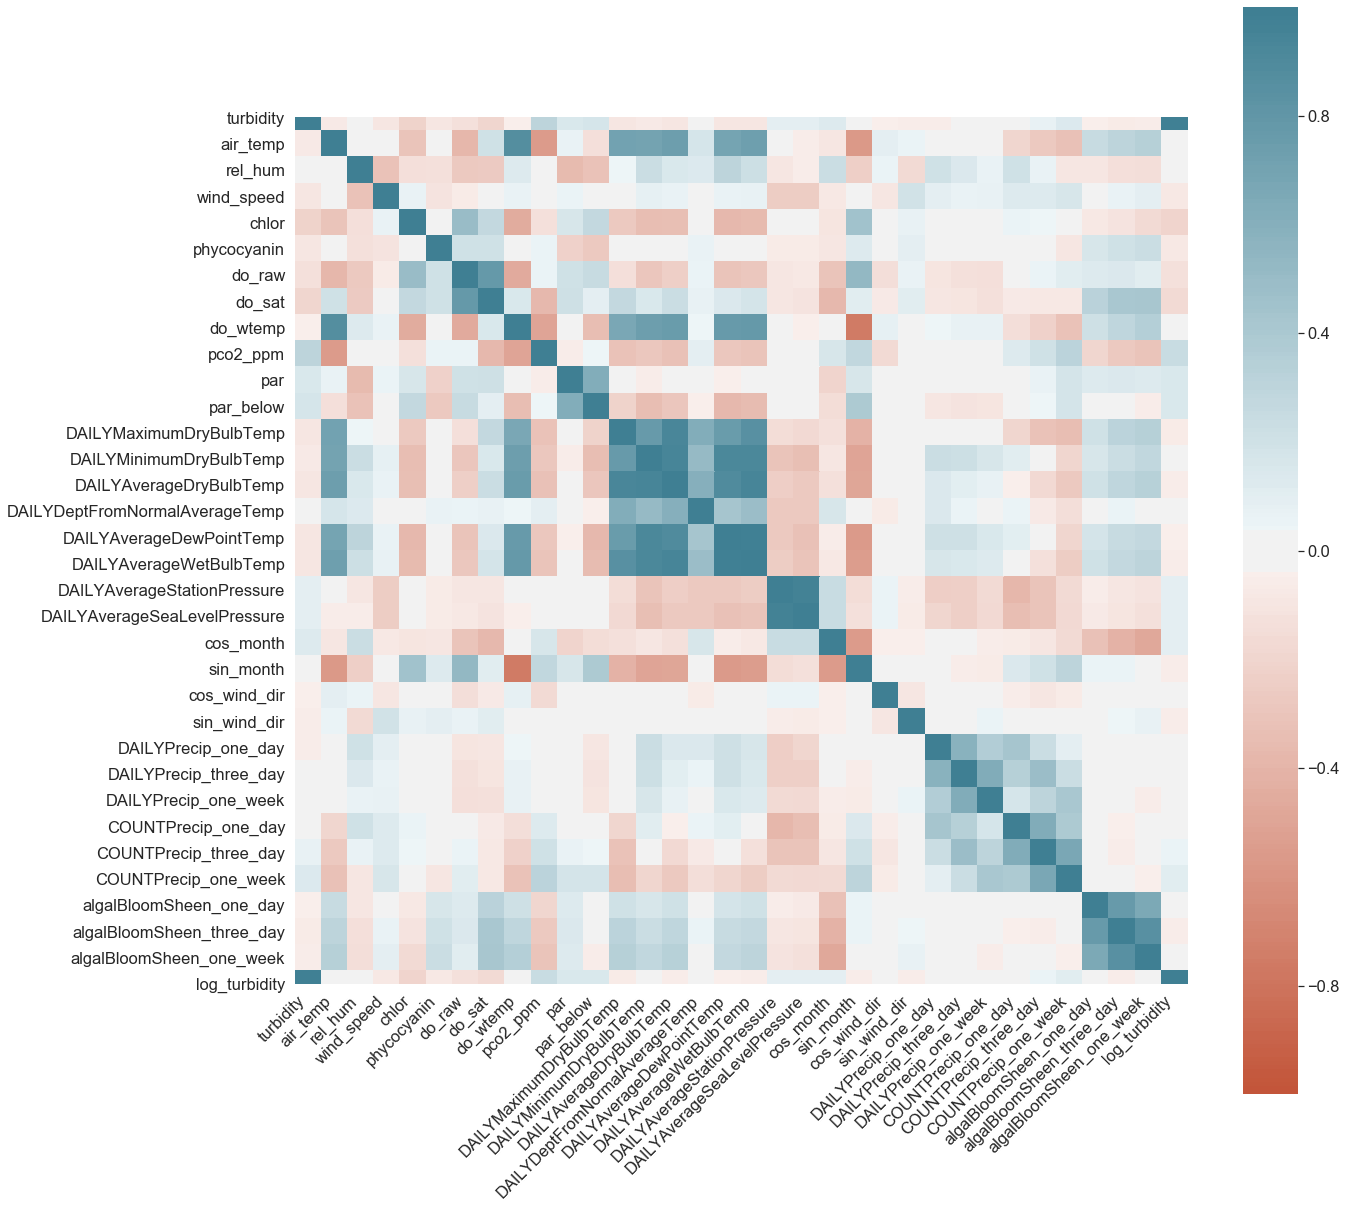

In [15]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Choose Correlated Features to Remove

Removed features: 
	 log_turbidity
	 do_wtemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


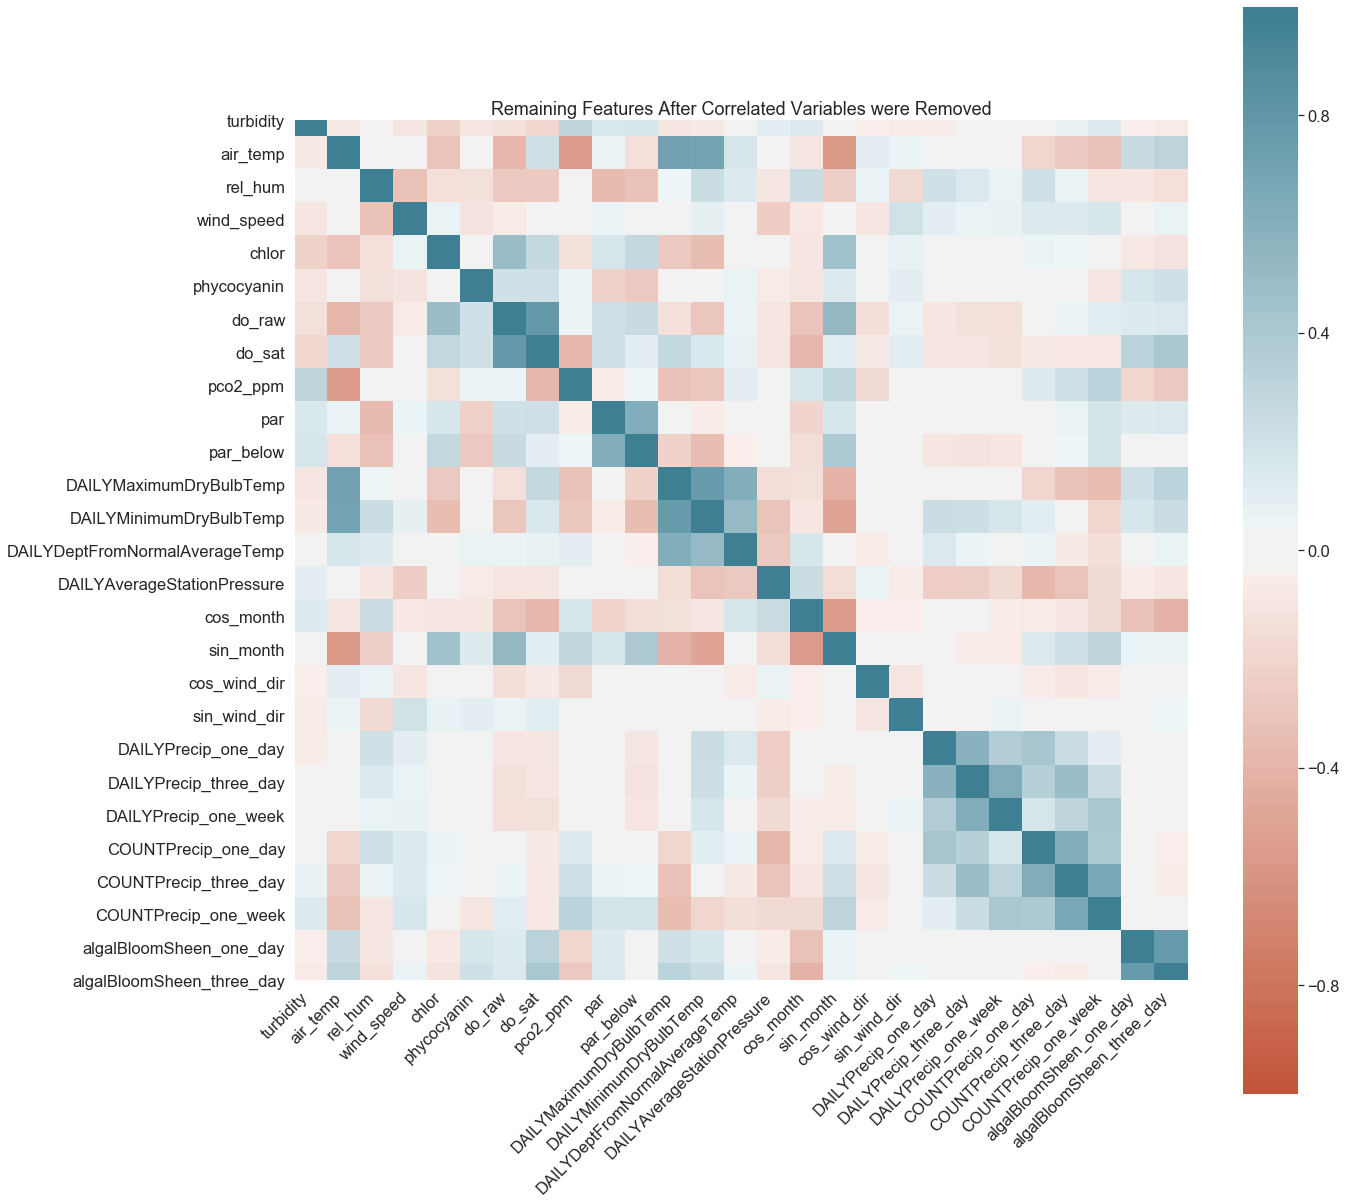

In [146]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])
                
# handpicked keep based on results above
# keep = ['turbidity', 'rel_hum', 'wind_speed', 'chlor',
#        'phycocyanin', 'do_sat', 'do_wtemp', 'pco2_ppm', 'par',
#        'par_below', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
#        'DAILYPrecip',
#        'DAILYAverageStationPressure',
#        'cos_month', 'sin_month', 'cos_wind_dir', 'sin_wind_dir',
#        'DAILYPrecip_one_day', 'DAILYPrecip_three_day', 'DAILYPrecip_one_week',
#        'algalBloomSheen_one_week']

new = data[keep]

new_corr = new.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    new_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Remaining Features After Correlated Variables were Removed');

## Define Models

In [141]:
log = LogisticRegression(    # gives more false positives, but not so many false negatives!!!!!
    penalty='l1',              # this model might be better without weather data actually
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

svc = SVC(                     # gives even slightly fewer false negatives than logic
    C=1,
    kernel='poly',
    degree=2,
    gamma='auto',
    coef0=1,
    probability=True,
    tol=0.001,
    class_weight='balanced',
    max_iter=10000
)

rfc = RandomForestClassifier(       # BEST MODEL
    n_estimators=1000,
    max_depth=4,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced'
)

mlp = MLPClassifier(
    hidden_layer_sizes=(20, 50, 50, 20),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=8,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    tol=0.0001,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    n_iter_no_change=10
)

########################################
########################################
########################################
# TODO TRY PARAMETER TUNING THE SVC, WILL POLY SVC WORK??                       -- DONE!!
# TODO TRY CHANGING ROLLING AND SHIFTED BOOLEAN PRECIP DATA TO ACTUAL AMOUNTS   -- DONE!!
# TODO TRY LOG TRANSFORMS AND MOVING AVERAGE AND STD ON SOME FEATURES
# TODO CROSS VALIDATED TRAINING CURVE                                           -- NOT APPLICABLE!!
# TODO TRY TRAINING ON ALL DATA BEFORE 2018, AND TEST ON DATA AFTER             -- DONE!!
# TODO TRY USING DATA ONLY FROM SAMPLING SEASON                                 -- DONE!!
# TODO TRY USING 2014 DATA                                                      -- DONE!!
# TODO ALSO TRY PARAMETER TUNING ON LOGISTIC REGRESSION                         -- DONE!! 
# TODO TRY ONLY OPTIMIZING F1 SCORE WHEN PARAMETER TUNING                       -- DONE!!
# TODO TRY FORECASTING MODEL                                                    -- DONE!!
# TODO CHECK CORRELATION AMONG VARIABLES                                        -- DONE!!
# TODO TRY REMOVING REDUNDANT FEATURES. THE PROBLEM IS THAT PREDICTIONS ARE
#    MADE ON AVERAGE DAILIES, WHICH IS SORT OF LIKE USING FUTURE DATA. TRY
#    ONLY USING BINARY OR DISCRETE FEATURES FOR DAILY AVERAGES, ETC DID IT
#    RAIN OR NOT?
# TODO HYPERPARAMETER TUNE MODELS FOR PREDICTING NEXT DAY 
########################################
########################################
########################################

## Run Model

### Split Data

In [142]:
df = data[keep]

X_train, X_test, y_train, y_test = train_test_split(
    df.values,
    labels.values.ravel(),
    train_size=0.7,
    test_size=0.3,
    shuffle=True,
    stratify=labels.values.ravel()
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Evaluate

Accuracy: 0.7120
Balanced Accuracy: 0.7120
F1 Score: 0.6099

Confusion Matrix:


,0,1
0,93,35
1,20,43


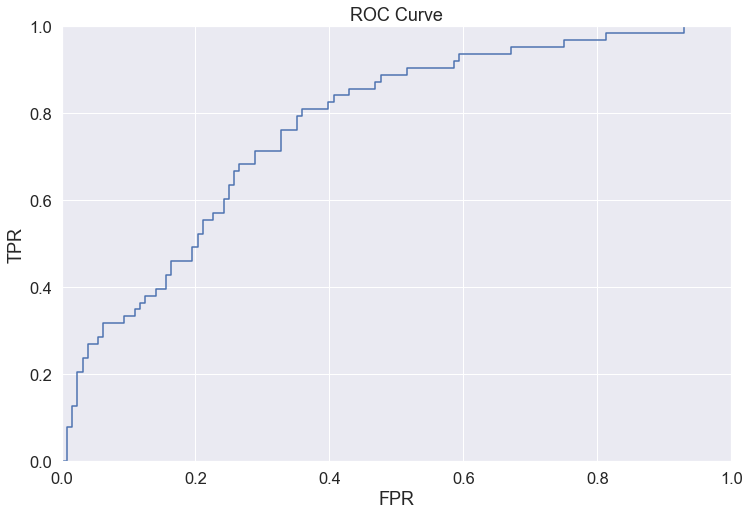

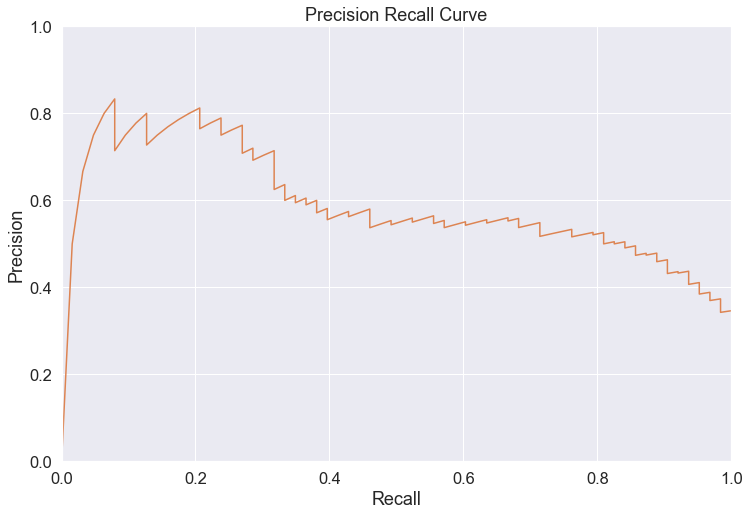

In [144]:
models = [log, svc, rfc, mlp]
m_idx = 0   # model index

m = models[m_idx]

m.fit(X_train, y_train)
y_pred = m.predict(X_test)
y_prob = m.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [145]:
# for use with logistic regression only
coef_sort_idx = np.argsort(-np.abs(m.coef_[0]), kind='mergesort')

print('Feature weighting for logistic regression\n')
for idx in coef_sort_idx:
    coef = m.coef_[0][idx]
    
    if coef < 0:
        print('\t%0.4f' % m.coef_[0][idx], df.columns[idx])
    else:
        print('\t %0.4f' % m.coef_[0][idx], df.columns[idx])

Feature weighting for logistic regression

	-1.2285 do_raw
	 1.2106 do_sat
	 0.5718 algalBloomSheen_three_day
	-0.4873 cos_month
	 0.4679 algalBloomSheen_one_day
	 0.2554 turbidity
	 0.2403 sin_month
	-0.2092 pco2_ppm
	-0.1880 air_temp
	 0.1450 DAILYAverageStationPressure
	-0.1391 wind_speed
	 0.1265 sin_wind_dir
	-0.1222 DAILYPrecip_one_week
	 0.1118 cos_wind_dir
	-0.0937 COUNTPrecip_one_day
	-0.0933 DAILYPrecip_three_day
	-0.0669 COUNTPrecip_one_week
	 0.0602 DAILYMaximumDryBulbTemp
	 0.0456 DAILYPrecip_one_day
	 0.0076 par_below
	-0.0029 rel_hum
	-0.0025 phycocyanin
	 0.0000 chlor
	 0.0000 par
	 0.0000 DAILYMinimumDryBulbTemp
	 0.0000 DAILYDeptFromNormalAverageTemp
	 0.0000 COUNTPrecip_three_day


## GridSearchCV

### Split Data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    data.values,
    labels.values.ravel(),
    train_size=0.7,
    test_size=0.3,
    shuffle=True,
    stratify=labels.values.ravel()
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest Classifier

In [29]:
rfc_params = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 2000],
    'criterion': ('gini', 'entropy'),
    'max_depth': [2, 3, 4, 5, 6, 7],
    'class_weight': ('balanced', 'balanced_subsample')
}

rfc_grid = GridSearchCV(
    estimator=rfc,
    param_grid=rfc_params,
    scoring='balanced_accuracy',    # or f1
    iid=False,
    n_jobs=3,
    cv=5
)

rfc_grid.fit(X_train, y_train)

print(rfc_grid.best_params_)

KeyboardInterrupt: 

In [ ]:
model = rfc_grid.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

#### Results

Run 1
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}

Accuracy: 0.7644
Balanced Accuracy: 0.7644
F1 Score: 0.6939

Confusion Matrix:
    0	1
0	95	33
1	12	51

### Logistic Regression

In [36]:
log_params = {
    'penalty': ('l1', 'l2'),
    'C': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000],
}

log_grid = GridSearchCV(
    estimator=log,
    param_grid=log_params,
    scoring='balanced_accuracy',    # or f1
    iid=False,
    n_jobs=3,
    cv=5
)

log_grid.fit(X_train, y_train)

print(log_grid.best_params_)

{'C': 2, 'penalty': 'l2'}


/Users/Alliot/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [43]:
model = log_grid.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)

Accuracy: 0.7487
Balanced Accuracy: 0.7487
F1 Score: 0.6757

Confusion Matrix:


,0,1
0,93,35
1,13,50


In [44]:
# for use with logistic regression only
coef_sort_idx = np.argsort(-np.abs(model.coef_[0]), kind='mergesort')

print('Feature weighting for logistic regression\n')
for idx in coef_sort_idx:
    coef = model.coef_[0][idx]
    
    if coef < 0:
        print('\t%0.4f' % model.coef_[0][idx], data.columns[idx])
    else:
        print('\t %0.4f' % model.coef_[0][idx], data.columns[idx])

Feature weighting for logistic regression

	-1.2717 do_raw
	 1.1430 do_sat
	 1.0407 DAILYAverageStationPressure
	-1.0217 DAILYAverageSeaLevelPressure
	 0.9626 algalBloomSheen_one_week
	 0.5095 DAILYAverageDryBulbTemp
	-0.3888 DAILYMinimumDryBulbTemp
	-0.3875 DAILYAverageDewPointTemp
	 0.3441 algalBloomSheen_one_day
	 0.3203 DAILYAverageWetBulbTemp
	-0.3017 cos_month
	-0.2834 DAILYPrecip_three_day
	-0.2549 wind_speed
	-0.2164 DAILYMaximumDryBulbTemp
	-0.2008 do_wtemp
	 0.1747 phycocyanin
	 0.1740 par_below
	 0.1714 sin_month
	-0.1644 COUNTPrecip_one_day
	 0.1513 turbidity
	 0.1408 DAILYPrecip_one_week
	-0.1119 pco2_ppm
	 0.1085 DAILYPrecip_one_day
	 0.0931 sin_wind_dir
	-0.0890 algalBloomSheen_three_day
	-0.0868 air_temp
	 0.0636 COUNTPrecip_three_day
	-0.0627 cos_wind_dir
	 0.0531 COUNTPrecip_one_week
	 0.0480 DAILYDeptFromNormalAverageTemp
	-0.0399 chlor
	-0.0366 par
	 0.0029 rel_hum


#### Results

Run 1
{'C': 1, 'penalty': 'l1'}

Accuracy: 0.7566
Balanced Accuracy: 0.7566
F1 Score: 0.6667

Confusion Matrix:
    0	1
0	97	29
1	17	46

### Multi-layer Perceptron

### Support Vector Classifier